# *BASECODE 작성*

* 가상환경 activate 후 lightgbm 설치
* conda install -c conda-forge lightgbm

In [103]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss

## 0. **데이터 로드**
* 훈련에 필요없는 index 컬럼 삭제
#### 변수
* train : `train.csv`
* test : `test.csv`

In [104]:
# 데이터 불러오기
train = pd.read_csv('./train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./sample_submission.csv')

### 데이터 전처리
http://www.dodomira.com/2016/10/20/how_to_eda/ 

링크 참고 

## 1. **데이터 셋 확인**

* 이전 EDA 코드 돌려봤기에 코드를 직접 합치지는 않았음

In [105]:
train.info()
test.info()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [106]:
# 각 유형 갯수 확인
count_type = [0, 0, 0] # object, int64, float64
for col in train.columns:
    if train[col].dtype == 'object':
        count_type[0] += 1
    elif train[col].dtype == 'int64':
        count_type[1] += 1
    elif train[col].dtype == 'float64':
        count_type[2] += 1
display(count_type)

[8, 7, 4]

#### object 8개, int64 7개 , float64 4개 있음.
-------------------------

## 2. **결측치 처리**
* 결측치는 직업 유형에만 존재함 -> 'unfilled'로 대체함. 
* 향후 '직업 유형의 결측치를 어떻게 해결할 것 인가' 고민이 필요함.

In [107]:
test['occyp_type'].count

<bound method Series.count of 0                  NaN
1           Core staff
2             Laborers
3              Drivers
4             Managers
             ...      
9995       Accountants
9996          Laborers
9997    Medicine staff
9998               NaN
9999          Laborers
Name: occyp_type, Length: 10000, dtype: object>

In [108]:
test['occyp_type'].isnull().sum()

3152

In [109]:
# 결측치 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

훈련데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64
테스트데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64


In [110]:
# 결측치 처리
print()
train['occyp_type'].fillna('unfilled', inplace=True) # 직업 유형 경우, 결측치가 많아서 따로 'unfilled' 라고 채움
test['occyp_type'].fillna('unfilled', inplace=True)

# 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())


훈련데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64
테스트데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
dtype: int64


## 3. **이상치 처리**
* 정수형, 실수형 데이터에서 이상치 찾아보고, 그에 맞게 처리하자.

In [111]:
display(len(train.columns))
display((train.columns))

19

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

### **3-1. 각 컬럼 데이터 변환 and 이상치 처리**
* 정수/실수형 데이터를 가진 10개 컬럼 중 휴대전화/직장전화/가정용전화/이메일 보유여부는 이상치 없음. (1아니면 0이니깐)
* 이 외에 6개 컬럼들 하나씩 살펴보기
 * 6개: 자녀 수, 가족 규모, 연간 소득, 출생일, 업무 시작일, 신용카드 발급 월 
 * 또한 분석하기 용이하게 데이터 변경 (ex) 부호 변환 or 일 수를 나이로)

#### 1) 자녀 수
* 2명 -> 3명 -> 4명. 

In [112]:
print('train childnum unique:', train['child_num'].unique())

train childnum unique: [ 0  1  2  3  4  5 14 19  7]


childnum unique: [0 1 2]


<AxesSubplot:xlabel='child_num'>

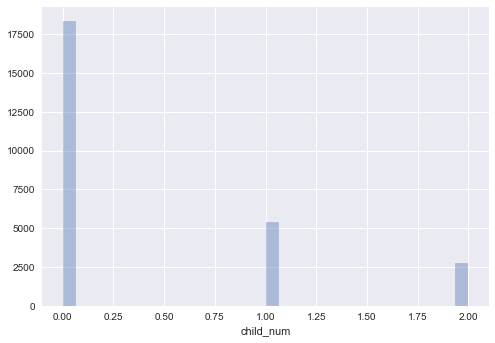

In [113]:
# 아이가 3명 이상인 데이터는 2로 변경
train.loc[train['child_num'] >= 3,'child_num'] = 2
print('childnum unique:', train['child_num'].unique())
sns.distplot(train['child_num'], kde=False, label='child_num')

#### 2) 가족 규모

In [114]:
print('train familysize unique:', train['family_size'].unique())

train familysize unique: [ 2.  3.  4.  1.  5.  6.  7. 15. 20.  9.]


In [115]:
train.loc[train['family_size'] >= 5,'family_size'] = 4

train familysize unique: [2. 3. 4. 1.]


<AxesSubplot:xlabel='family_size'>

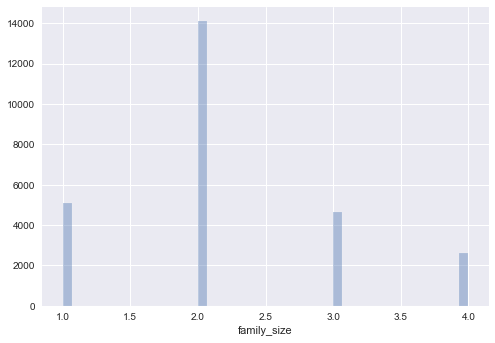

In [116]:
print('train familysize unique:', train['family_size'].unique())
sns.distplot(train['family_size'], kde=False, label='family_size')

#### 3) 연간 소득
* 테스트 데이터에서도 박스플롯 밖의 값이 많이 있기에 박스플롯 밖의 값 제거 안하기로 결정

Text(0.5, 1.0, 'test Boxplot of income_total')

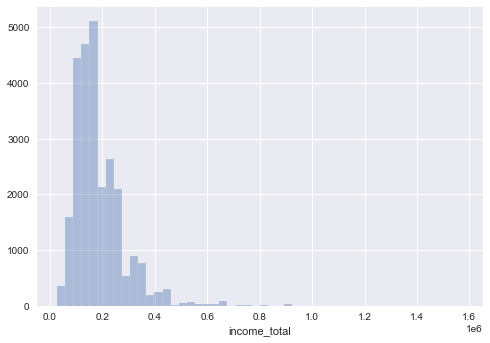

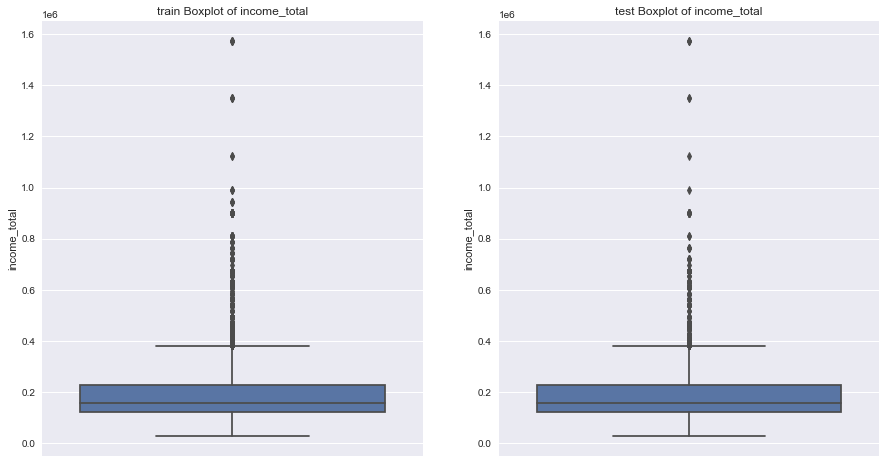

In [117]:
sns.distplot(train['income_total'], kde=False, label='income_total')
fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.boxplot(y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("train Boxplot of income_total")

sns.boxplot(y=test["income_total"],data=test, ax=ax[1])
ax[1].set_title("test Boxplot of income_total")

#### 4) 출생일 -> 나이
* 양수 변환 후 나이로 변환
* 정수형으로 변환

In [118]:
def days_to_age(x):
    return (x*-1)/365

# train
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(days_to_age)
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(train['DAYS_BIRTH'])

# test
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(days_to_age)
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(test['DAYS_BIRTH'])

0        38
1        31
2        52
3        41
4        41
         ..
26452    33
26453    41
26454    27
26455    27
26456    53
Name: DAYS_BIRTH, Length: 26457, dtype: int32

0       60
1       51
2       43
3       52
4       48
        ..
9995    50
9996    29
9997    57
9998    45
9999    25
Name: DAYS_BIRTH, Length: 10000, dtype: int32

#### 5) 업무시작일 -> 업무 연차
* 양수 변환 후 연차로 변환
    * 단, 365243은 0연차로 변환
    * 135일 일한 사람과 0연차를 구분하기 위해서 0연차를 제외하고 모두 +1 해줌
* 정수형으로 변환

In [119]:
def days_to_year(x):
    if x==365243 :
        return 0
    return (x*-1)/365+1

# train
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(days_to_year)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(train['DAYS_EMPLOYED'])

# test
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(days_to_year)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(test['DAYS_EMPLOYED'])

0        13
1         5
2        13
3         6
4         6
         ..
26452     6
26453     7
26454     6
26455     1
26456     3
Name: DAYS_EMPLOYED, Length: 26457, dtype: int32

0        0
1       24
2        1
3        7
4       26
        ..
9995    15
9996     4
9997    39
9998     3
9999     1
Name: DAYS_EMPLOYED, Length: 10000, dtype: int32

#### 6) 신용카드 발급 월

* 양수로 변환

In [120]:
def minus(x):
    return x * -1

# train
train['begin_month'] = train['begin_month'].apply(minus)
display(train['begin_month'])

# test
test['begin_month'] = test['begin_month'].apply(minus)
display(test['begin_month'])

0         6.0
1         5.0
2        22.0
3        37.0
4        26.0
         ... 
26452     2.0
26453    47.0
26454    25.0
26455    59.0
26456     9.0
Name: begin_month, Length: 26457, dtype: float64

0       60
1       36
2       40
3       41
4        8
        ..
9995    19
9996    34
9997    55
9998    33
9999    11
Name: begin_month, Length: 10000, dtype: int64

#### 7) 박스 플롯을 통한 이상치 확인
* 박스플롯

In [121]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int32  
 10  DAYS_EMPLOYED  26457 non-null  int32  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     26457 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

* 1) 신용카드 발급 월
* 2) 업무 연차
* 3) 나이
* 4) 연간 수입
 * 4개 컬럼에 대해 박스플롯 그려보기

Text(0.5, 1.0, "Boxplot of test's begin_month")

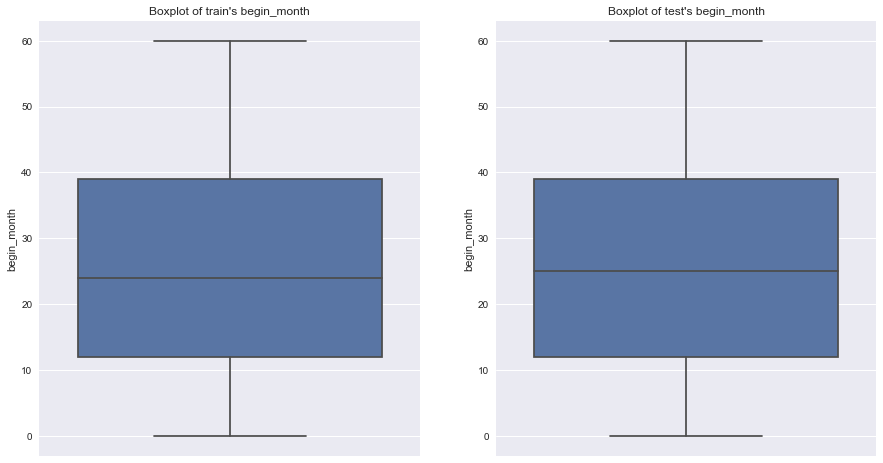

In [122]:
# 신용카드 발급 월의 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["begin_month"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's begin_month")

sns.boxplot(y=test["begin_month"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's begin_month")

Text(0.5, 1.0, "Boxplot of test's DAYS_BIRTH")

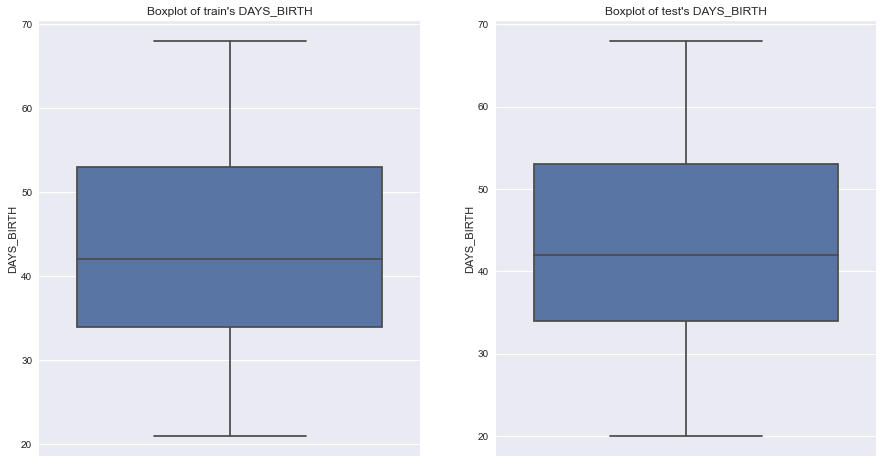

In [123]:
# 나이에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["DAYS_BIRTH"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's DAYS_BIRTH")

sns.boxplot(y=test["DAYS_BIRTH"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's DAYS_BIRTH")

Text(0.5, 1.0, "Boxplot of test's income_total")

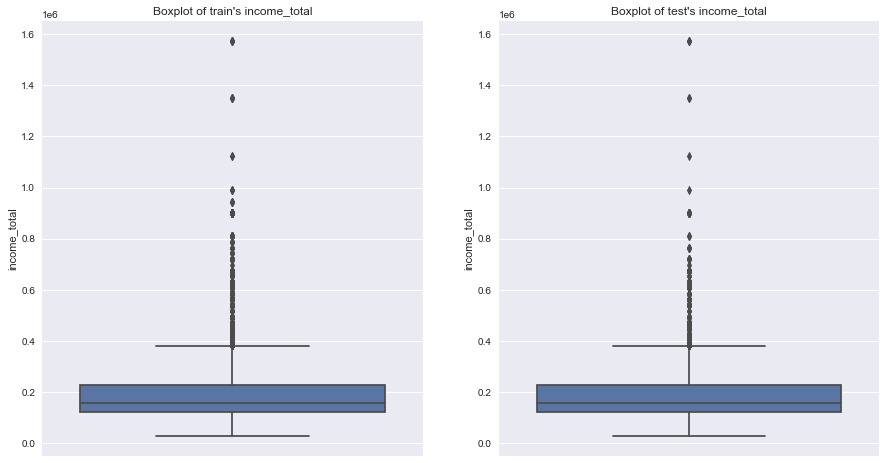

In [124]:
# 연간 수입에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's income_total")

sns.boxplot(y=test["income_total"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's income_total")

Text(0.5, 1.0, "Boxplot of test's DAYS_EMPLOYED")

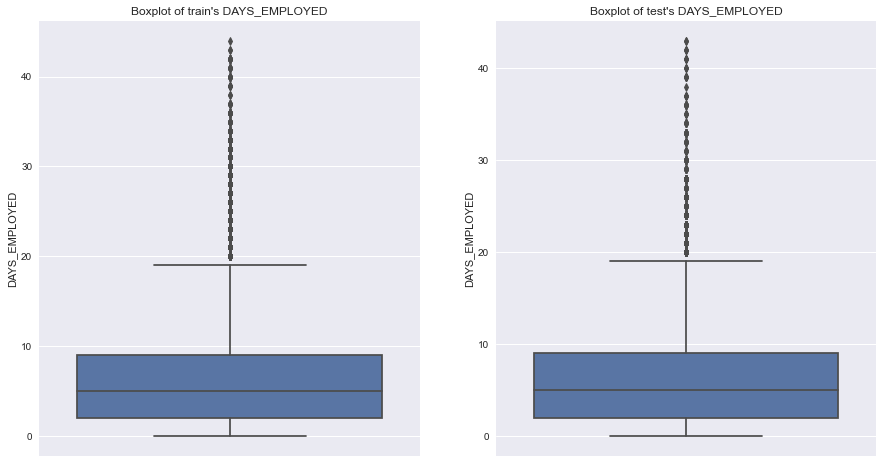

In [125]:
# 업무 연차에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["DAYS_EMPLOYED"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's DAYS_EMPLOYED")

sns.boxplot(y=test["DAYS_EMPLOYED"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's DAYS_EMPLOYED")

Text(0.5, 1.0, 'Boxplot of family_size')

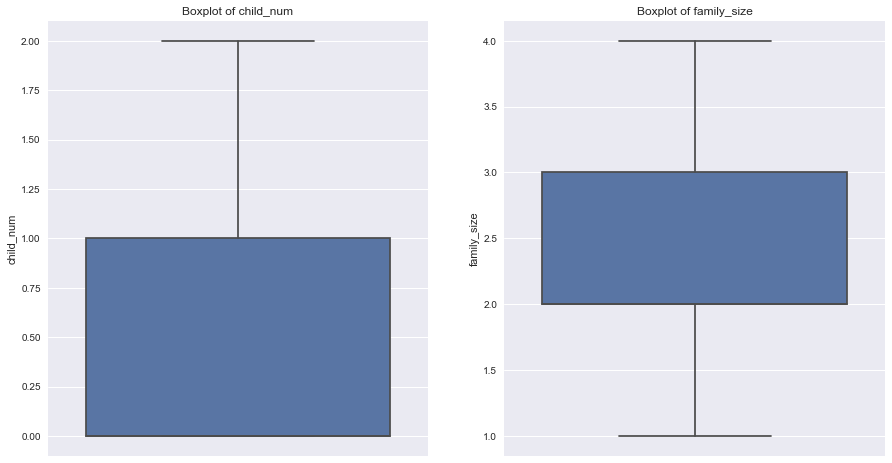

In [126]:
# child_num, family_size
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["child_num"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of child_num")

sns.boxplot(y=train["family_size"],data=train, ax=ax[1])
ax[1].set_title("Boxplot of family_size")

#### 8) 상관관계
* 범주형과 수치형 상관관계 확인 - https://dodonam.tistory.com/217

<AxesSubplot:>

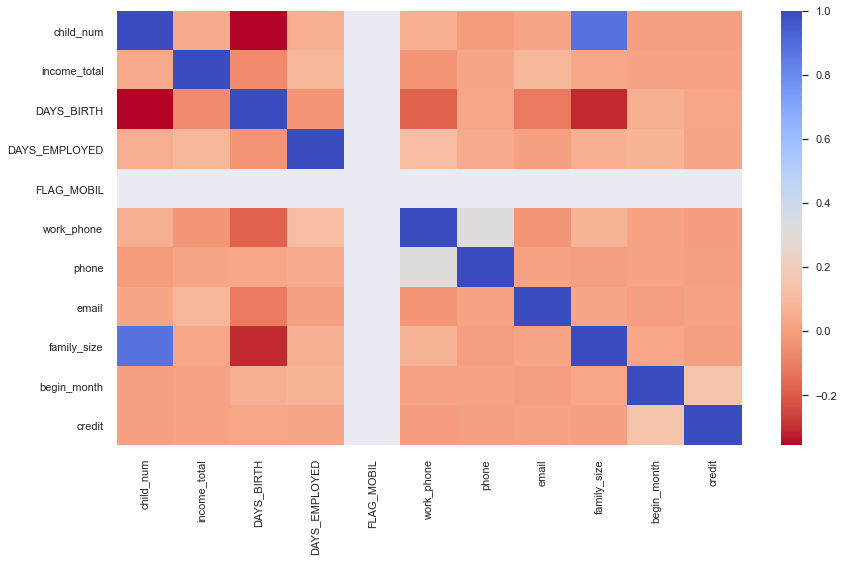

In [127]:
#상관관계를 확인
sns.set(rc={'figure.figsize':(14,8)})
corr = train.corr()
sns.heatmap(corr, cmap='coolwarm_r')

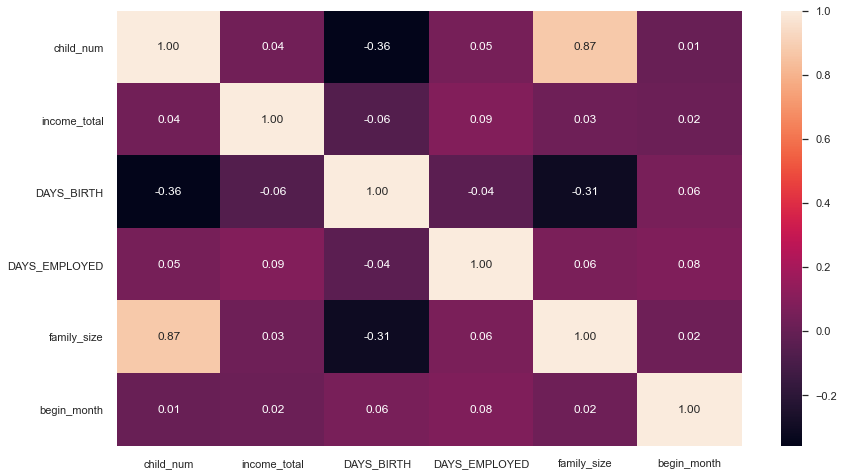

In [128]:
# 다중 공선성 확인
list_numeric = ["child_num", "income_total", "DAYS_BIRTH", "DAYS_EMPLOYED", "family_size", "begin_month"]
sns.heatmap(train[list_numeric].corr(), annot = True, fmt = ".2f")
plt.show()

In [129]:
#상관관계 수치로 확인
# 종속변수('Class')와의 상관관계
Corr = train.corr()
IF = Corr['credit'].sort_values().to_frame()
display(IF.head(5))
print(IF)

,credit
work_phone,-0.003134
child_num,0.003441
phone,0.003452
family_size,0.007979
income_total,0.008555


                 credit
work_phone    -0.003134
child_num      0.003441
phone          0.003452
family_size    0.007979
income_total   0.008555
email          0.014812
DAYS_EMPLOYED  0.023476
DAYS_BIRTH     0.025059
begin_month    0.147477
credit         1.000000
FLAG_MOBIL          NaN


* 신용도와 가장 상관관계가 높은 컬럼은 "begin_month" 이나 0.147에 불과함

#### 9) 회귀분석 그래프

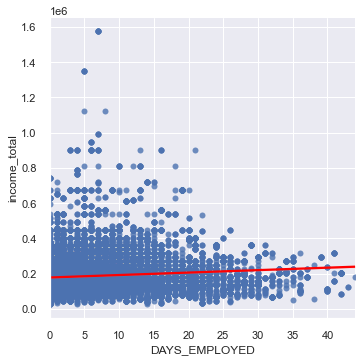

In [130]:
# 9-1. 연차와 연간 소득의 회귀분석 그래프
# 연차가 낮은데 소득이 굉장히 많은 경우는 제거해도 좋을 듯
sns.lmplot(x="DAYS_EMPLOYED", y="income_total", data=train, line_kws={'color':"red"})

## 4. **Feature Engineering** - 여기에 정규화 포함시켜야 할듯요!

* 수치형 컬럼은 기존 데이터 분포와 비슷하고, 어느정도 일정한 범위를 갖게 정규화해야함
* 각 컬럼마다 동일한 스케일러 적용할 필요는 없음. 
* [다른 스케일러 적용한 사례- 블로그](https://lsjsj92.tistory.com/555?category=853217)

### 4-1. 범주형 데이터 one-hot encoding, label encoding
* object (범주형)은 원핫인코딩 하기.
    * 단, occyp_type은 라벨 인코딩.
* 범주형 데이터를 가지는 변수 확인 (dtype가 object)
* gender(2), car(2), reality(2), income_type(5), edu_type(5), family_type(5), house_type(6), occyp_type(18)

In [131]:
# object 객체를 가지는 변수(열) 확인
object_col = []
for col in train.columns:
    if train[col].dtype == 'object' : # and col!='occyp_type': # 변수가 18개인 occyp_type만 제외
        object_col.append(col)
display(object_col)

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [132]:
print(train['occyp_type'].unique())
(len(train['occyp_type'].unique()))

['unfilled' 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Secretaries' 'HR staff' 'IT staff' 'Low-skill Laborers'
 'Waiters/barmen staff']


19

#### 4-1-1. train의 원핫인코딩, 라벨인코딩

In [133]:
# occyp_type을 제외한 모든 object객체 열을 onehot encoding

enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])

train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [134]:
# occyp_type을 label encoding

# label_encoder=preprocessing.LabelEncoder()
# train['occyp_type']=label_encoder.fit_transform(train['occyp_type'])

In [135]:
# 인코딩 확인

display(train.head(5))
print(train.columns)
train.info()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled
0,0,202500.0,38,13,1,0,0,0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,247500.0,31,5,1,0,0,1,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,450000.0,52,13,1,0,1,0,2.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,202500.0,41,6,1,0,1,0,2.0,37.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,157500.0,41,6,1,0,0,0,2.0,26.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'credit', 'gender_F', 'gender_M', 'car_N', 'car_Y',
       'reality_N', 'reality_Y', 'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'edu_type_Academic degree', 'edu_type_Higher education',
       'edu_type_Incomplete higher', 'edu_type_Lower secondary',
       'edu_type_Secondary / secondary special', 'family_type_Civil marriage',
       'family_type_Married', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Accountants', 'occyp_type_Cleaning staff',
       'occyp

#### 4-1-2. test의 원핫인코딩, 라벨인코딩

In [136]:
# occyp_type을 제외한 모든 object객체 열을  onehot encoding
enc = OneHotEncoder()
enc.fit(test.loc[:,object_col])

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [137]:
# occyp_type을 label encoding

# label_encoder=preprocessing.LabelEncoder()
# test['occyp_type']=label_encoder.fit_transform(test['occyp_type'])

In [138]:
# 인코딩 확인

display(test.head(5))
print(test.columns)
test.info()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled
0,0,112500.0,60,0,1,0,1,0,2,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,135000.0,51,24,1,0,1,0,2,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,69372.0,43,1,1,1,1,0,2,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,112500.0,52,7,1,1,0,0,2,41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,225000.0,48,26,1,1,0,0,2,8,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'gender_F', 'gender_M', 'car_N', 'car_Y', 'reality_N',
       'reality_Y', 'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'edu_type_Academic degree', 'edu_type_Higher education',
       'edu_type_Incomplete higher', 'edu_type_Lower secondary',
       'edu_type_Secondary / secondary special', 'family_type_Civil marriage',
       'family_type_Married', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Accountants', 'occyp_type_Cleaning staff',
       'occyp_type_Cook

### 4-2. 데이터 정규화

#### 정규화 전 분포도
* 수치형 데이터만

<AxesSubplot:xlabel='begin_month', ylabel='Density'>

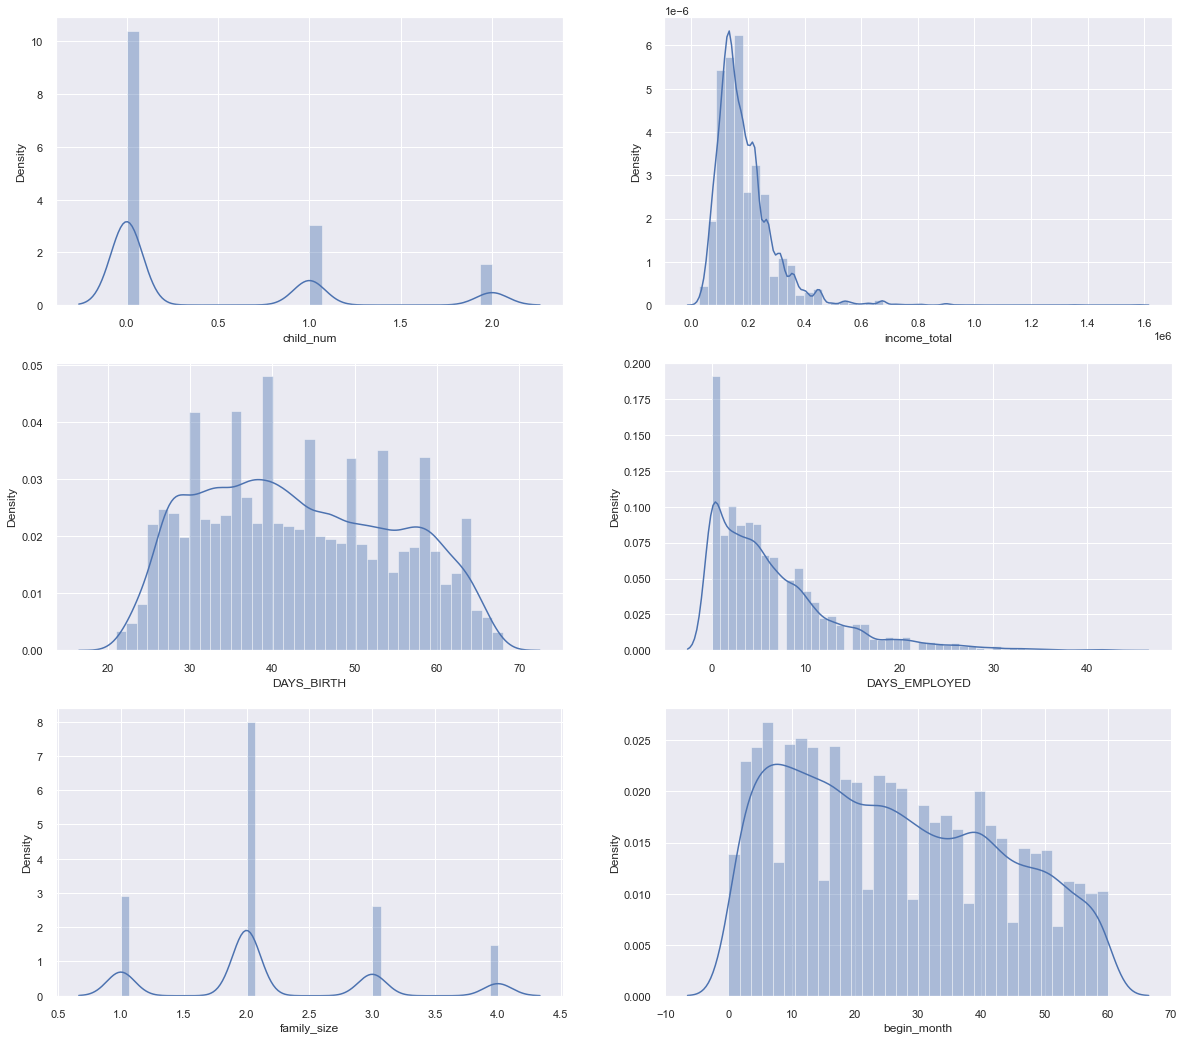

In [139]:
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(train['child_num'], ax=ax[0][0])
sns.distplot(train['income_total'], ax=ax[0][1])

sns.distplot(train['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(train['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(train['family_size'], ax=ax[2][0])
sns.distplot(train['begin_month'], ax=ax[2][1])

#### 4-2-1. MinMaxScaler

In [140]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler_data = train[train.columns.difference(['credit'])].copy()

minMaxScaler = MinMaxScaler()
print(minMaxScaler.fit(MinMaxScaler_data))
train_data_minMaxScaled = minMaxScaler.transform(MinMaxScaler_data)

# MinMaxScaler_data - MinMaxScaler적용한 데이터 프레임
index = 0
for col in MinMaxScaler_data.columns :
    MinMaxScaler_data[col] = train_data_minMaxScaled[:,index]
    index = index + 1
display(MinMaxScaler_data)

MinMaxScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,0.361702,0.295455,0.0,0.100000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.212766,0.113636,0.0,0.083333,1.0,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.659574,0.295455,0.0,0.366667,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.425532,0.136364,0.0,0.616667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.425532,0.136364,0.0,0.433333,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.255319,0.136364,0.0,0.033333,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26453,0.425532,0.159091,0.0,0.783333,1.0,0.0,0.5,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26454,0.127660,0.136364,0.0,0.416667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26455,0.127660,0.022727,0.0,0.983333,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<AxesSubplot:xlabel='begin_month', ylabel='Density'>

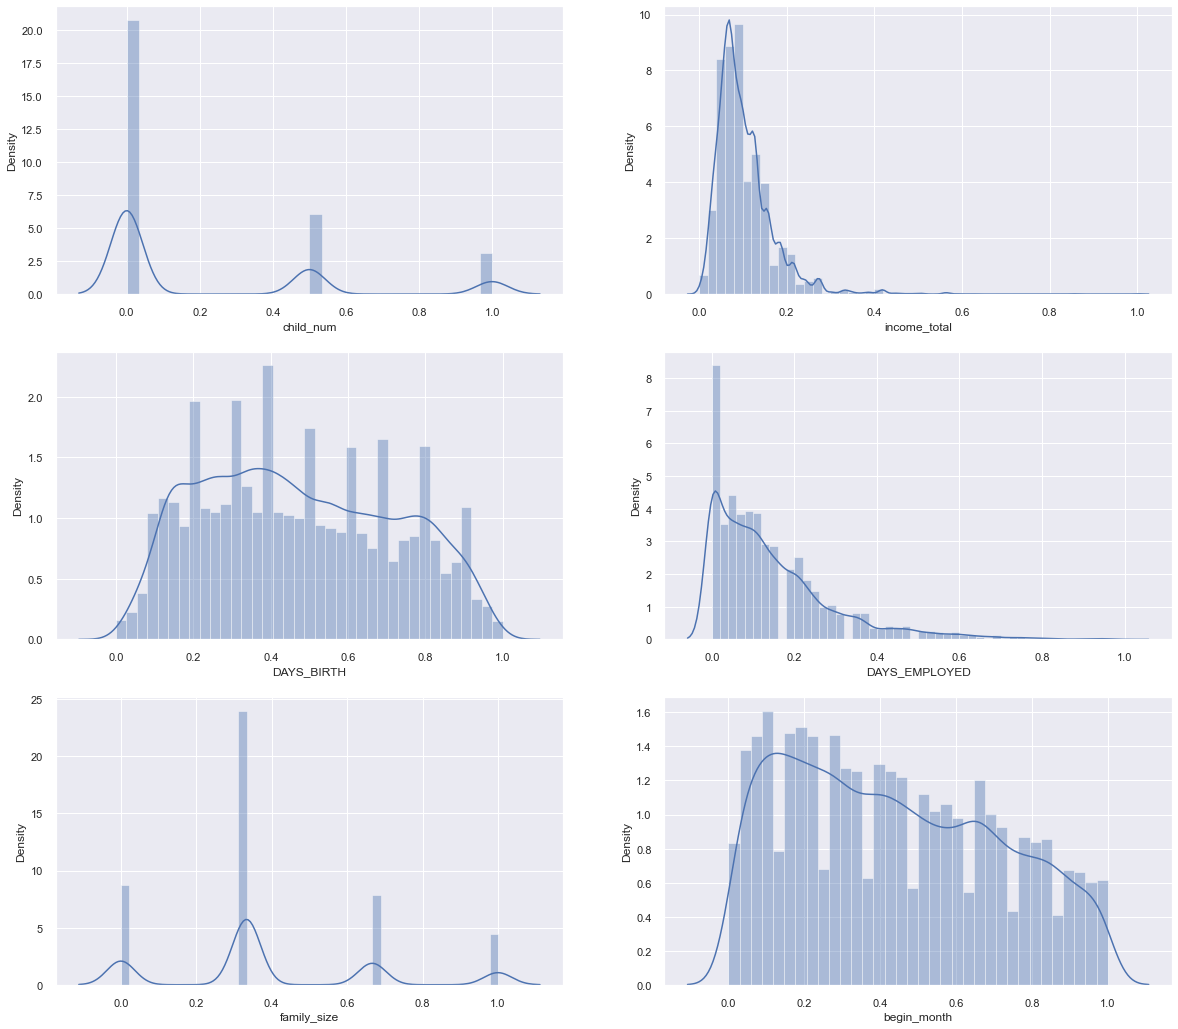

In [141]:
# MinMaxScaler 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(MinMaxScaler_data['child_num'], ax=ax[0][0])
sns.distplot(MinMaxScaler_data['income_total'], ax=ax[0][1])

sns.distplot(MinMaxScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(MinMaxScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(MinMaxScaler_data['family_size'], ax=ax[2][0])
sns.distplot(MinMaxScaler_data['begin_month'], ax=ax[2][1])

#### 4-2-2 MaxAbsScaler

In [142]:
from sklearn.preprocessing import MaxAbsScaler

MaxAbsScaler_data = train[train.columns.difference(['credit'])].copy()

maxAbsScaler = MaxAbsScaler()
print(maxAbsScaler.fit(MaxAbsScaler_data))
train_data_maxAbsScaled = maxAbsScaler.transform(MaxAbsScaler_data)

# MaxAbsScaler_data - MaxAbsScaler 적용한 데이터 프레임
index = 0
for col in MaxAbsScaler_data.columns :
    MaxAbsScaler_data[col] = train_data_maxAbsScaled[:,index]
    index = index + 1
display(MaxAbsScaler_data)

MaxAbsScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,0.558824,0.295455,1.0,0.100000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.455882,0.113636,1.0,0.083333,1.0,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.764706,0.295455,1.0,0.366667,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.602941,0.136364,1.0,0.616667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.602941,0.136364,1.0,0.433333,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.485294,0.136364,1.0,0.033333,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26453,0.602941,0.159091,1.0,0.783333,1.0,0.0,0.5,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26454,0.397059,0.136364,1.0,0.416667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26455,0.397059,0.022727,1.0,0.983333,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,0.361702,0.295455,0.0,0.100000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.212766,0.113636,0.0,0.083333,1.0,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.659574,0.295455,0.0,0.366667,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.425532,0.136364,0.0,0.616667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.425532,0.136364,0.0,0.433333,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.255319,0.136364,0.0,0.033333,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26453,0.425532,0.159091,0.0,0.783333,1.0,0.0,0.5,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26454,0.127660,0.136364,0.0,0.416667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26455,0.127660,0.022727,0.0,0.983333,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


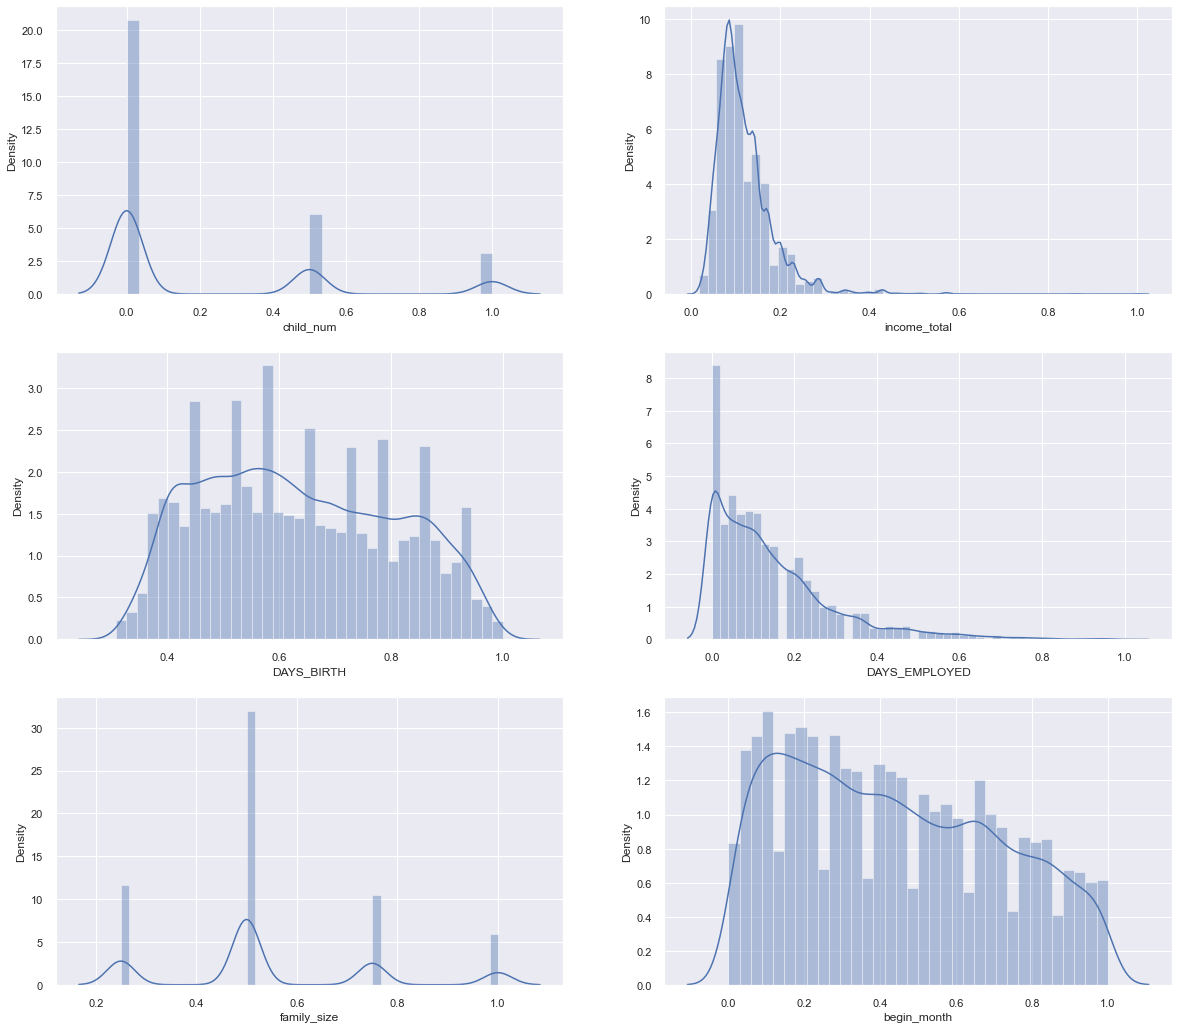

In [143]:
# MaxAbsScaler_data 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(MaxAbsScaler_data['child_num'], ax=ax[0][0])
sns.distplot(MaxAbsScaler_data['income_total'], ax=ax[0][1])

sns.distplot(MaxAbsScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(MaxAbsScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(MaxAbsScaler_data['family_size'], ax=ax[2][0])
sns.distplot(MaxAbsScaler_data['begin_month'], ax=ax[2][1])


MinMaxScaler_data


#### 4-2-3 StandardScaler

In [144]:
from sklearn.preprocessing import StandardScaler

StandardScaler_data = train[train.columns.difference(['credit'])].copy()

standardScaler = StandardScaler()
print(standardScaler.fit(StandardScaler_data))
train_data_standardScaled = standardScaler.transform(StandardScaler_data)

# StandardScaler_data - StandardScaler 적용한 데이터 프레임
index = 0
for col in StandardScaler_data.columns :
    StandardScaler_data[col] = train_data_standardScaled[:,index]
    index = index + 1
display(StandardScaler_data)

StandardScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,-0.452819,0.996418,0.0,-1.215231,0.782463,-0.782463,-0.612349,-0.029497,1.641365,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,1.495966,-0.645705,1.437626,-1.437626,-0.538417
1,-1.060808,-0.219047,0.0,-1.275620,0.782463,-0.782463,0.881099,-0.029497,-0.609249,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,-0.645705,-0.695591,0.695591,-0.538417
2,0.763158,0.996418,0.0,-0.249003,-1.278015,1.278015,-0.612349,-0.029497,1.641365,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,1.548696,-0.695591,0.695591,-0.538417
3,-0.192253,-0.067114,0.0,0.656836,0.782463,-0.782463,-0.612349,-0.029497,-0.609249,-0.200248,...,-0.048856,3.069242,-0.060662,-0.127621,-0.068622,-0.668464,1.548696,-0.695591,0.695591,-0.538417
4,-0.192253,-0.067114,0.0,-0.007446,-1.278015,1.278015,-0.612349,-0.029497,1.641365,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,-0.645705,-0.695591,0.695591,-0.538417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,-0.887097,-0.067114,0.0,-1.456788,0.782463,-0.782463,2.374547,-0.029497,-0.609249,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,-0.645705,1.437626,-1.437626,-0.538417
26453,-0.192253,0.084819,0.0,1.260729,0.782463,-0.782463,0.881099,-0.029497,1.641365,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,1.495966,-0.645705,-0.695591,0.695591,-0.538417
26454,-1.408230,-0.067114,0.0,-0.067835,-1.278015,1.278015,-0.612349,-0.029497,-0.609249,-0.200248,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,-0.645705,1.437626,-1.437626,-0.538417
26455,-1.408230,-0.826780,0.0,1.985400,0.782463,-0.782463,-0.612349,-0.029497,-0.609249,4.993820,...,-0.048856,-0.325813,-0.060662,-0.127621,-0.068622,-0.668464,-0.645705,-0.695591,0.695591,-0.538417


<AxesSubplot:xlabel='begin_month', ylabel='Density'>

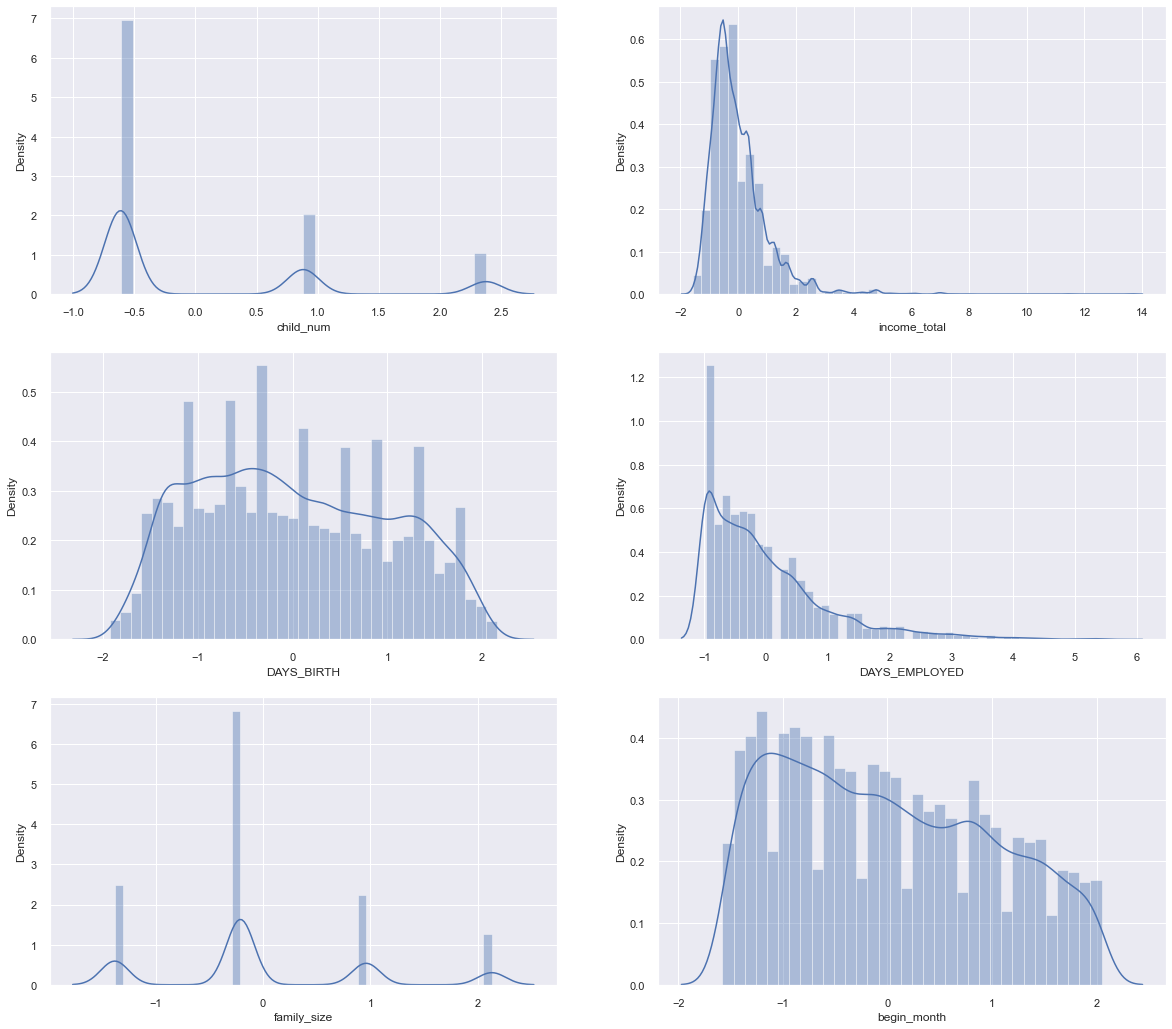

In [145]:
# MaxAbsScaler_data 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(StandardScaler_data['child_num'], ax=ax[0][0])
sns.distplot(StandardScaler_data['income_total'], ax=ax[0][1])

sns.distplot(StandardScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(StandardScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(StandardScaler_data['family_size'], ax=ax[2][0])
sns.distplot(StandardScaler_data['begin_month'], ax=ax[2][1])

#### 4-2-4 RobustScaler

In [146]:
from sklearn.preprocessing import RobustScaler

RobustScaler_data = train[train.columns.difference(['credit'])].copy()

robustScaler = RobustScaler()
print(robustScaler.fit(RobustScaler_data))
train_data_robustScaled = robustScaler.transform(RobustScaler_data)

# StandardScaler_data - StandardScaler 적용한 데이터 프레임
index = 0
for col in RobustScaler_data.columns :
    RobustScaler_data[col] = train_data_robustScaled[:,index]
    index = index + 1
display(RobustScaler_data)

RobustScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,-0.210526,1.142857,0.0,-0.666667,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0
1,-0.578947,0.000000,0.0,-0.703704,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.526316,1.142857,0.0,-0.074074,-1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.052632,0.142857,0.0,0.481481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.052632,0.142857,0.0,0.074074,-1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,-0.473684,0.142857,0.0,-0.814815,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
26453,-0.052632,0.285714,0.0,0.851852,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26454,-0.789474,0.142857,0.0,0.037037,-1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
26455,-0.789474,-0.571429,0.0,1.296296,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='begin_month', ylabel='Density'>

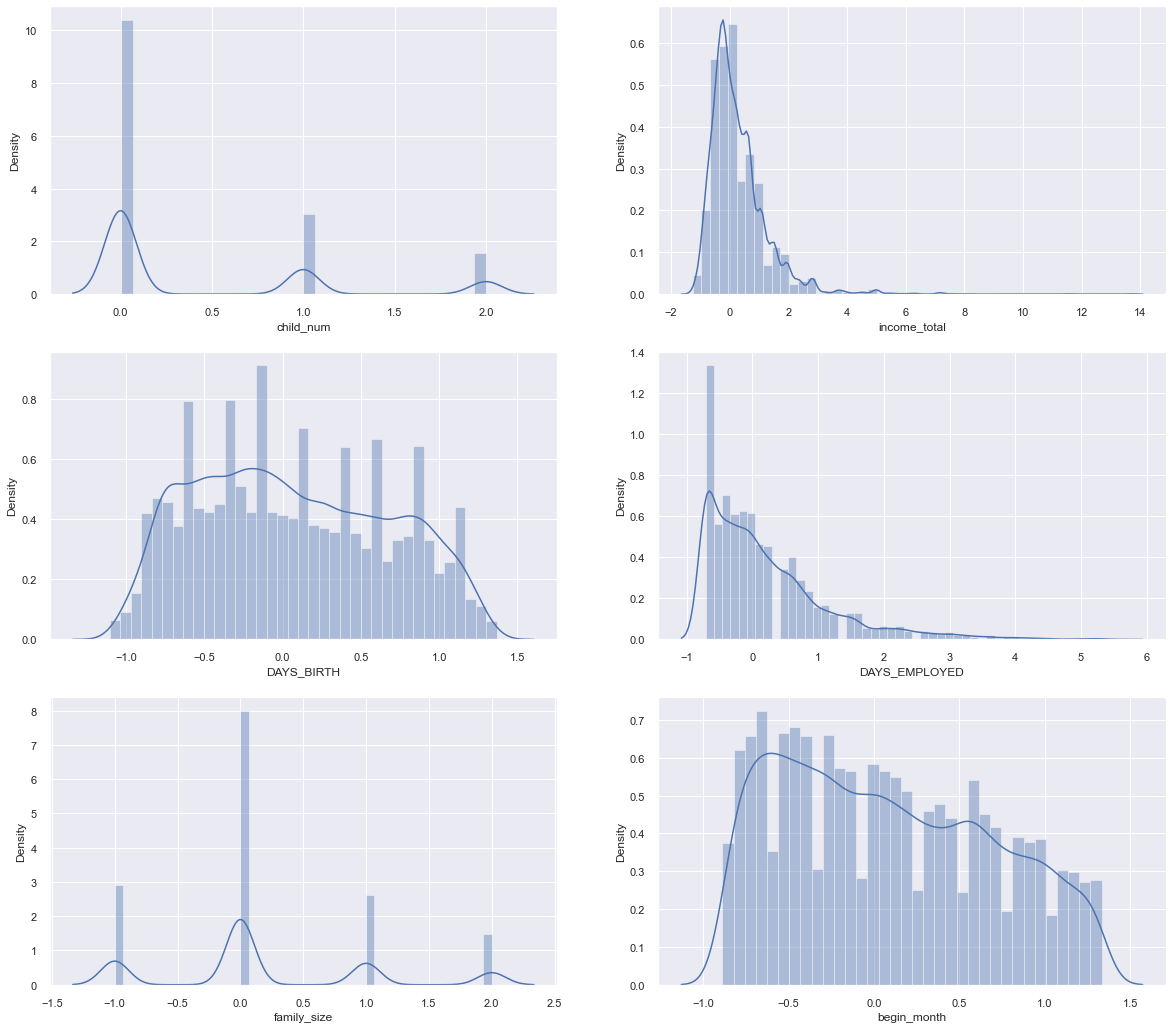

In [147]:
# MaxAbsScaler_data 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(RobustScaler_data['child_num'], ax=ax[0][0])
sns.distplot(RobustScaler_data['income_total'], ax=ax[0][1])

sns.distplot(RobustScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(RobustScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(RobustScaler_data['family_size'], ax=ax[2][0])
sns.distplot(RobustScaler_data['begin_month'], ax=ax[2][1])

In [148]:
# test.csv 정규화
from sklearn import preprocessing
testSet = test.copy()
testSet = preprocessing.MinMaxScaler().fit(testSet).transform(testSet)

-----------------------------------------------
## 여기까지 정규화, 이상치 처리 완료해야 함, 데이터 전처리 단계

#### 정규화한 데이터 이름
* MinMaxScaler_data
* MaxAbsScaler_data
* StandardScaler_data
* RobustScaler_data

## 5. 모델링

### 5-0 데이터 분리
* 데이터 분리는 stratifiedKFold를 사용하여 y값 분포를 비슷하게 분리 시킴 -> 5-fold
    * StratifiedKFold(계층별 k-겹 교차검증) - 불균형한 분포도를 가진 레이블 데이터를 위한 방식, 특정 레이블 값이 너무 많거나 적은 경우
    * 타겟에 속성값의 개수를 동일하게 가져감으로써 kfold 같이 데이터가 한곳으로 몰리는 것을 방지
    * 대부분의 경우 회귀에서는 k-겹 교차 검증, 분류에서는 계층별 k-겹 교차검증의 기본값이 잘 작동함
* n_split는 몇 개로 분할할지 결정
* shtffle은 데이터 섞어서 샘플의 순서 랜덤하게. 
* 데이터를 섞을 때 random_state를 고정해서 똑같은 작업을 재현할 수있음
* 그렇지 않으면 cross_val_score를 실행할 때마다 폴드가 바뀌어 매번 결과가 달라짐

In [149]:
# 설명변수 X, 예측변수 y 할당 (사용하고자하는 정규화 스케일러로 변경 가능)
X = MinMaxScaler_data
Y = train['credit']

In [150]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
folds=[]

# 계층별 k-겹 교차검증을 위해 인덱스를 나누는 코드
for train_index, valid_index in skf.split(X, Y):
    folds.append((train_index, valid_index))
display(folds)

[(array([    0,     1,     3, ..., 26453, 26454, 26456]),
  array([    2,    26,    45, ..., 26446, 26452, 26455])),
 (array([    2,     3,     6, ..., 26454, 26455, 26456]),
  array([    0,     1,     4, ..., 26435, 26447, 26450])),
 (array([    0,     1,     2, ..., 26453, 26454, 26455]),
  array([    3,    12,    16, ..., 26438, 26448, 26456])),
 (array([    0,     1,     2, ..., 26454, 26455, 26456]),
  array([    6,    14,    29, ..., 26440, 26442, 26453])),
 (array([    0,     1,     2, ..., 26453, 26455, 26456]),
  array([    7,     9,    10, ..., 26449, 26451, 26454]))]

* 여기서 앞으로 계속 사용할 X,Y, folds 저장되어 있음

### 5-1. LGBM
[LGBM 모델 설명](https://lsjsj92.tistory.com/548)
#### Training    
* LGBM의 기본 파라미터로 훈련
* 30번 이상 개선 없을 경우 중단.
* 각 5개의 fold를 훈련하여 저장

In [151]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # LGBM 모델 돌리기, 
    # 30번 이상 개선 없을 시 중단, 5개의 fold를 훈련하여 저장
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    
    y_hat = lgb.predict(X_valid)
    lgb_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(lgb_matrix)
    lgb_report = metrics.classification_report(Y_valid, y_hat)
    print(lgb_report)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.66269	valid_1's multi_logloss: 0.758233
[200]	training's multi_logloss: 0.58201	valid_1's multi_logloss: 0.747494
[300]	training's multi_logloss: 0.521385	valid_1's multi_logloss: 0.743413
Early stopping, best iteration is:
[337]	training's multi_logloss: 0.501536	valid_1's multi_logloss: 0.7425
[[  80   79  486]
 [  22  425  807]
 [  35  112 3246]]
              precision    recall  f1-score   support

         0.0       0.58      0.12      0.20       645
         1.0       0.69      0.34      0.45      1254
         2.0       0.72      0.96      0.82      3393

    accuracy                           0.71      5292
   macro avg       0.66      0.47      0.49      5292
weighted avg       0.69      0.71      0.66      5292



====================================2============================================
Traini

#### Test inference
* 각 폴드를 훈련시킨 LGBM으로 예측
* 해당 대회는 logloss score를 겨루는 것이기 때문에 각 class의 probability를 얻어야함
* 대부분의 머신러닝 모델에서 predict, predict_proba를 구분하여 사용함.
* predict는 class 출력을 해주고 predict_proba는 class 별 probability를 출력해줌
* predict_proba를 사용하여 예측한 것을 5-fold 더하여 평균내어 앙상블함

In [152]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(testSet)/5
submit.to_csv('./LGBM_test_0422.csv', index=False) # 0.7272812144
submit.head(20)

,index,0,1,2
0,26457,0.235913,0.760851,0.003236
1,26458,0.006749,0.019446,0.973805
2,26459,0.094924,0.904060,0.001016
3,26460,0.007788,0.111580,0.880632
4,26461,0.002487,0.055646,0.941867
5,26462,0.475005,0.293795,0.231200
6,26463,0.005199,0.173184,0.821617
7,26464,0.085598,0.912823,0.001579
8,26465,0.317584,0.154516,0.527900
9,26466,0.265918,0.321785,0.412298


### 5-2. **로지스틱 회귀분석**

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

random.seed(42)
logR_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    logmodel = LogisticRegression()
    logmodel.fit(X_train, Y_train)  
    y_hat = logmodel.predict(X_valid)
    
    logR_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(logR_matrix)
    logR_report = metrics.classification_report(Y_valid, y_hat)
    print(logR_report)
    
    print('학습용 데이터셋 정확도 : %.5f' % logmodel.score(X_train, Y_train))
    print('검증용 데이터셋 정확도 : %.5f' % logmodel.score(X_valid, Y_valid))
    print(f'Log Loss: {log_loss(Y_valid, logmodel.predict_proba(X_valid)):.6f}')
    logR_models[fold]=logmodel
    print(f'================================================================================\n\n')

====================================1============================================
[[   0   11  634]
 [   0   26 1228]
 [   0   16 3377]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       645
         1.0       0.49      0.02      0.04      1254
         2.0       0.64      1.00      0.78      3393

    accuracy                           0.64      5292
   macro avg       0.38      0.34      0.27      5292
weighted avg       0.53      0.64      0.51      5292

학습용 데이터셋 정확도 : 0.64337
검증용 데이터셋 정확도 : 0.64305
Log Loss: 0.866943


====================================2============================================
[[   0    5  640]
 [   0   19 1235]
 [   0    7 3386]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       645
         1.0       0.61      0.02      0.03      1254
         2.0       0.64      1.00      0.78      3393

    accuracy                           0.64      5292
   mac

In [154]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += logR_models[fold].predict_proba(testSet)/5

submit.to_csv('./logR_0422.csv', index=False)
submit.head(20)

,index,0,1,2
0,26457,0.144298,0.451231,0.404471
1,26458,0.287304,0.116133,0.596563
2,26459,0.227002,0.277379,0.495619
3,26460,0.281477,0.159378,0.559145
4,26461,0.157905,0.077783,0.764312
5,26462,0.221051,0.392766,0.386183
6,26463,0.250848,0.214397,0.534755
7,26464,0.250301,0.198320,0.551379
8,26465,0.110553,0.478104,0.411343
9,26466,0.183960,0.433017,0.383023


In [155]:
# from sklearn.metrics import classification_report
# y_pred=log.predict(X_test)
# print(classification_report(y_test, y_pred))

# 아래 결과는 md파일 참고
# print(log.predict_proba(test))

### 5-3 KNN

In [ ]:
# # 시간 진 ~ 짜 오래걸리니까 ... 변한거 없으면 그냥 돌리지 마세요 ....!

# # 최적 k 도출 - Cross Validation 이용
# from sklearn.model_selection import cross_val_score
# from sklearn.neighbors import KNeighborsClassifier

# k_range = range(1,50) # 1~100 에서 최적 k 찾기
# k_scores = []

# for k in k_range :
#     print(k)
#     knn = KNeighborsClassifier(k)
#     scores = cross_val_score(knn, X, y, cv=10, scoring = "accuracy") # 10-fold cross validation
#     k_scores.append(scores.mean())
    

# # 최적 k를 그래프로 확인    
# plt.plot(k_range, k_scores)
# plt.xlabel('value of K for KNN')
# plt.ylabel('Cross_Validation Accuracy')
# plt.show()

# # k_scores 리스트에서 최댓값의 index 구하기 (최적 k 찾기)
# k = k_scores.index(max(k_scores)) + 1
# print(k)

In [ ]:
random.seed(42)

# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn import metrics 

knn_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # knn 모델
    knn = KNeighborsClassifier(n_neighbors=19) # 75로 해놓음
    knn.fit(X_train, Y_train)
    y_hat = knn.predict(X_valid)
    
    knn_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(knn_matrix)
    
    knn_report = metrics.classification_report(Y_valid, y_hat)
    print(knn_report)

    print(log_loss(Y_valid, knn.predict_proba(X_valid)))

    knn_models[fold]=knn
    print(f'================================================================================\n\n')

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += knn_models[fold].predict_proba(testSet)/5

submit.to_csv('./knn_0422.csv', index=False)
submit.head(20)

In [ ]:
# # 최적 k로 모델 학습
# # sklearn 라이브러리에서 KNN 분류 모형 가져오기
# from sklearn.neighbors import KNeighborsClassifier

# # 모형 객체 생성 (최적 k 사용)
# knn = KNeighborsClassifier(n_neighbors=75) # 75로 해놓음

# # train data를 가지고 모형 학습
# knn.fit(X_train, y_train)

# # test data를 가지고 예측(분류)하고 예측값을 y_hat에 저장
# y_hat = knn.predict(X_test)

# # 시각적으로 확인해보기
# print(y_hat[0:10])
# print(y_test.values[0:10])

### 5-4. SVM

In [ ]:
random.seed(42)

from sklearn import svm
from sklearn.metrics import log_loss
from sklearn import metrics 

SVM_models={}

for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    svm_model = svm.SVC(kernel='rbf', probability=True)
    svm_model.fit(X_train, Y_train)   
    y_hat = svm_model.predict(X_valid)
    svm_matrix = metrics.confusion_matrix(Y_valid, y_hat)  
    print(svm_matrix)
    print('\n')
    svm_report = metrics.classification_report(Y_valid, y_hat)            
    print(svm_report)
    print(svm_model.predict_proba(X_valid))
    print('log_loss :', log_loss(Y_valid, svm_model.predict_proba(X_valid)))
    SVM_models[fold]=svm_model
    print(f'================================================================================\n\n')

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += SVM_models[fold].predict_proba(testSet)/5

submit.to_csv('./SVM_0422.csv', index=False)
submit.head(20)